In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        self.tik = time.time()
        
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.09574 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

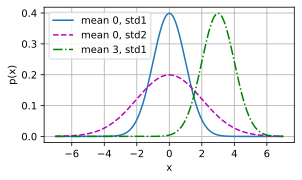

In [7]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
        ylabel='p(x)', figsize=(4.5, 2.5),
        legend=[f'mean {mu}, std{sigma}' for mu, sigma in params])

In [8]:
def synthetic_data(w, b, num_examples):
    '''生成 y = Xw + b + 噪声 '''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [9]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [10]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.0107, -1.5528]) 
label: tensor([9.4541])


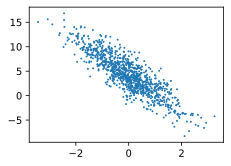

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [12]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [13]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.1344,  1.0639],
        [-0.4220, -3.4301],
        [ 0.3691,  0.9827],
        [-0.5222, -0.6242],
        [ 2.1520,  0.6453],
        [ 0.9554,  0.6119],
        [-2.3458,  1.7299],
        [-0.1750,  0.5355],
        [-0.6508,  0.0775],
        [-0.4614, -0.0797]]) 
 tensor([[-3.6948],
        [15.0379],
        [ 1.5899],
        [ 5.2812],
        [ 6.2887],
        [ 4.0139],
        [-6.3664],
        [ 2.0334],
        [ 2.6259],
        [ 3.5434]])


In [14]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [15]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [16]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [17]:
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 参数更新阶段不进行梯度的计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 此时 l 的形状是 batch_size * 1
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad(): # 推理阶段不进行梯度的计算
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031239
epoch 2, loss 0.000114
epoch 3, loss 0.000051


In [19]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([4.4596e-04, 2.5749e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


In [20]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [21]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个 PyTorch 数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [22]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [23]:
next(iter(data_iter))

[tensor([[ 1.3701,  0.6867],
         [-0.9035,  0.6047],
         [ 0.2522,  0.6330],
         [-1.8697, -0.5175],
         [-1.0920, -1.8034],
         [-0.0508,  0.3265],
         [-0.8354, -1.4516],
         [ 0.8691,  0.1543],
         [ 1.3827, -0.7472],
         [-0.5341, -1.5723]]),
 tensor([[4.5964],
         [0.3366],
         [2.5553],
         [2.2232],
         [8.1577],
         [2.9764],
         [7.4780],
         [5.4213],
         [9.5033],
         [8.4768]])]

In [24]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [25]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [26]:
loss = nn.MSELoss()

In [27]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [28]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        # trainer.zero_grad()
        l.backward()
        trainer.step()
        trainer.zero_grad()
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000293
epoch 2, loss 0.000108
epoch 3, loss 0.000107


In [29]:
w = net[0].weight.data
b = net[0].bias.data
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0005,  0.0010])
b的估计误差: tensor([0.0001])


In [30]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [31]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

In [32]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [33]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [34]:
def get_fashion_mnist_labels(labels):
    '''返回 Fashion-MNIST数据集的文本标签'''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [35]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

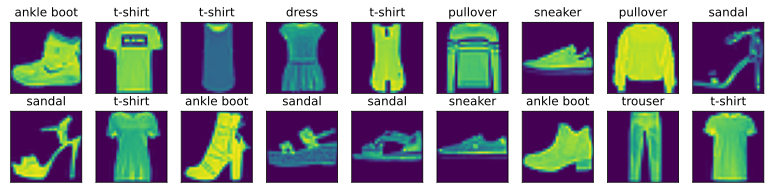

In [36]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18))) # 每次读取 18 张图片 X:18*1*28*28
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [37]:
batch_size = 256

def get_dataloader_workers():
    '''使用4个进程来读取数据'''
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [38]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.50 sec'

In [39]:
def load_data_fashion_mnist(batch_size, resize=None):
    '''下载Fashion-MNIST数据集，然后将其加载到内存中'''
    trans = [transforms.ToTensor()]
    if resize: # 调整图像大小
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))

In [40]:
train_iter, test_iter = load_data_fashion_mnist(32)
# train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 28, 28]) torch.float32 torch.Size([32]) torch.int64


In [41]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [42]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

In [43]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [44]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [45]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [46]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [47]:
accuracy(y_hat, y) / len(y)

0.5

In [48]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [49]:
class Accumulator:
    """在 `n` 个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [50]:
evaluate_accuracy(net, test_iter)

0.0621

In [51]:
def train_epoch_ch3(net, train_iter, loss, updater):
    '''训练模型一个迭代周期'''
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用 PyTorch 内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [52]:
from IPython import display

class Animator:
    '''在动画中绘制数据'''
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用 lambda 函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [53]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    '''训练模型'''
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [54]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

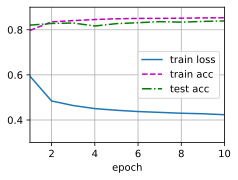

In [55]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

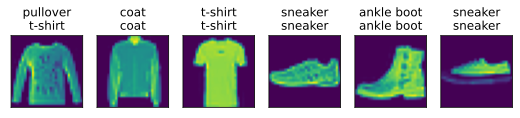

In [56]:
def predict_ch3(net, test_iter, n=6):
    '''预测标签'''
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0: n].reshape((n, 28, 28)), 1, n, titles=titles[0: n])

predict_ch3(net, test_iter)

In [57]:
import torch
from torch import nn
from d2l import torch as d2l

In [58]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [59]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
    
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [60]:
loss = nn.CrossEntropyLoss()

In [61]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

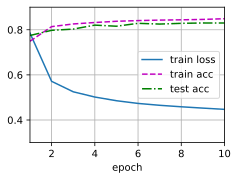

In [62]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)